## LSTM Classifier for Signals and Noise

This notebook demonstrate the possible use of LSTM recurrent neural network (RNN) in order to distinguish between a known signal and noise. The known signal is a 1MHz sinewave while the noise is gaussian.

- Both signal and noise is (virtually) sampled at 20MHz for a time duration of 10 milliseconds.
- Signal frequency is 1MHz
- Noise is gaussian where mean is 0 and standard deviation is 0.2.
- The extracted segments contains 1000 sample points each.
- Both signal and noise values were shifted to a range between 0 and 99 in order to use in ML.
- When creating training and testing samples, both signal and noise samples were created in equal numbers, i.e., 50% signal traces and 50% noise traces.
- Tested version: Python-3.7.2 and Tensorflow-1.13.1.

Reference:
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [1]:
from emvincelib import iq, ml, stat
import numpy as np
import time
import serial
import os
from sklearn.model_selection import train_test_split

### Supporting functions

In [2]:
%matplotlib inline
import numpy as np
from scipy import signal as sg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

def getSignalTrace(duration):
    '''
    This function generates a 1MHz sinewave along with Gaussian noise.
    Input: time duration of the sine wave signal segment
    Out: a numpy array containing signal segment
    '''
    # Sampling Rate
    Fs = 20e6       
    # Frequency (in Hz)
    f = 1e6               
    #duration = 10e-3 # 10 milliseconds        
    duration = duration * 0.001 # milliseconds to seconds
    # Number of samples 
    num_samples = int(duration * Fs)
    x = np.arange(num_samples)
    signal = 5*np.sin(2 * np.pi * f * x / Fs)
    mean = 0
    std = 0.2
    noise = 2*np.random.normal(mean, std, num_samples)
    trace = signal + noise
    #result = trace[0:length]
    #result = 50 * result
    #result[result < 0] = 0
    #result[result > 99] = 99
    #return result
    return trace

def getNoiseTrace(duration):
    '''
    This function generates a Gaussian noise.
    Input: length of the noise segment
    Out: a numpy array containing noise segment
    '''
    # Sampling Rate
    Fs = 20e6       
    #duration = 10e-3 # 10 milliseconds        
    duration = duration * 0.001 # milliseconds to seconds
    # Number of samples 
    num_samples = int(duration * Fs)
    mean = 0
    std = 0.2
    noise = 2*np.random.normal(mean, std, num_samples)
    #result = noise[0:length]
    #result = 50 * result
    #result[result < 0] = 0
    #result[result > 99] = 99
    #return result
    return noise


### Plotting sample signals and noise segments

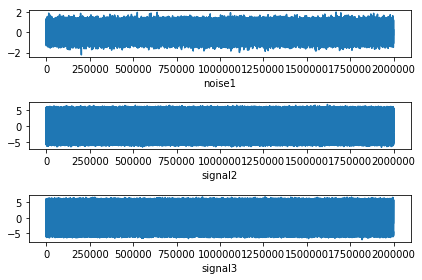

In [3]:
length=1000

signal1 = getSignalTrace(100)
#signal1 = 50 * signal1
signal2 = getSignalTrace(100)
#signal2 = 50 * signal2
signal3 = getSignalTrace(100)
#signal3 = 50 * signal3

noise1 = getNoiseTrace(100)
#noise1 = 50 * noise1
noise2 = getNoiseTrace(100)
#noise2 = 50 * noise2

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(noise1)
plt.xlabel("noise1")
plt.subplot(3, 1, 2)
plt.plot(signal2)
plt.xlabel("signal2")
plt.subplot(3, 1, 3)
plt.plot(signal3)
plt.xlabel("signal3")
plt.tight_layout()
plt.show()

### Collecting EM traces

In [4]:
curve_name = "signal"
for i in range(10):
    file_name = curve_name + "." + str(i)
    data_directory = "./data/originals"
    signal = getSignalTrace(100)
    file_name = data_directory + "/" + curve_name + "." + str(i) + ".npy"
    np.save(file_name, signal)
    print("Collected trace", i)
    time.sleep(2)
    
curve_name = "noise"
for i in range(10):
    file_name = curve_name + "." + str(i)
    data_directory = "./data/originals"
    signal = getNoiseTrace(100)
    file_name = data_directory + "/" + curve_name + "." + str(i) + ".npy"
    np.save(file_name, signal)
    print("Collected trace", i)
    time.sleep(2)

Collected trace 0
Collected trace 1
Collected trace 2
Collected trace 3
Collected trace 4
Collected trace 5
Collected trace 6
Collected trace 7
Collected trace 8
Collected trace 9
Collected trace 0
Collected trace 1
Collected trace 2
Collected trace 3
Collected trace 4
Collected trace 5
Collected trace 6
Collected trace 7
Collected trace 8
Collected trace 9


### Generating samples for machine learning classification

In [5]:
# function to collect overlapping training segments from an EM trace
def slidingWindowSegmenting(traceArray, segmentFileName, initWindowNumber=1, sampleRate=20e6, windowSize=10, windowStepSize=5):
    samplesPerWindow = int(sampleRate * (windowSize * 0.001))
    samplesPerStep = int(sampleRate * (windowStepSize * 0.001))
    startIndex = 0
    endIndex = startIndex + samplesPerWindow 
    i=initWindowNumber
    while(endIndex <= len(traceArray)):
        #print("file=", i, "Trace=", len(traceArray), " StartIndex=", startIndex, "EndIndex=", endIndex, "SamplesPerStep=", samplesPerStep)
        fileName = segmentFileName + "." + str(i) + ".npy"
        #print(fileName)
        feature_vector = ml.getFeatureVector(traceArray[startIndex:endIndex])
        np.save(fileName, feature_vector)   
        
        startIndex = startIndex + samplesPerStep
        endIndex = startIndex + samplesPerWindow 
        i = i + 1
    print("number of files saved:", i)
    nextWindowNumber = i
    return nextWindowNumber

traceNumber = 0

In [6]:
listOfFiles = os.listdir("./data/originals")
# shuffling the training sequences
listOfFiles = np.array(listOfFiles)
np.random.shuffle(listOfFiles)
listOfFiles = listOfFiles.tolist()
#print(listOfFiles)

initWindowNumber = 0
traceNumber = 0

for fileName in listOfFiles:
    #print(fileName)
    cryptoName, index, extension = fileName.split(".") 
    traceFileName = "./data/originals/" + fileName
    segmentFileName = "./data/training/" + cryptoName + "." + str(traceNumber)
    trace = np.load(traceFileName, mmap_mode='r')
    slidingWindowSegmenting(trace, segmentFileName, initWindowNumber=initWindowNumber, windowSize=10, windowStepSize=5)
    traceNumber = traceNumber + 1
    

number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19
number of files saved: 19


In [7]:
def loadDataToXY(trainingFilePath, num_sequences, num_time_steps, num_dimensions):
    pathToNpyFiles = trainingFilePath
    X = np.empty(shape=(num_sequences, num_time_steps, num_dimensions, 0))
    #print(X.shape)
    X = X.tolist()
    y = np.empty(num_sequences, dtype = str) 
    y = y.tolist()

    listOfFiles = os.listdir(pathToNpyFiles)
    # shuffling the training sequences
    #listOfFiles = np.array(listOfFiles)
    #np.random.shuffle(listOfFiles)
    #listOfFiles = listOfFiles.tolist()
    for fileName in listOfFiles:
        #print(fileName)
        cryptoName, traceNumber, windowNumber, extension = fileName.split(".")   
        #y.append(cryptoName)
        y[int(traceNumber)] = cryptoName
        fftloaded = np.load(pathToNpyFiles+"/"+fileName)
        #feature_vector = np.random.randint(2, size=1000)
        X[int(traceNumber)][int(windowNumber)] = fftloaded      
    return X, y

### LSTM classification of signal and noise

In [8]:
# LSTM for sequence classification
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

num_sequences = 20 # number of EM traces
num_time_steps = 19 # number of windows per trace
num_dimensions = 1000 # size of the feature vector


X, y = loadDataToXY("./data/training", num_sequences, num_time_steps, num_dimensions)
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)


# encoding class labels
y[y=='noise'] = 0
y[y=='signal'] = 1
y = y.astype(np.int)

# Splitting samples to training and testing sets
test_size = 0.25
test_size = int(num_sequences * test_size)
#print("test size=", test_size)
#print("train size=", test_size+1)
X_test = X[:test_size]
X_train = X[(test_size):]
y_test = y[:test_size]
y_train = y[(test_size):]


#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)
#print(y_test)
#print(y_train)
#y = to_categorical(y)
#print(y)

# fix random seed for reproducibility
numpy.random.seed(7)

# create the model
model = Sequential()

#model.add(Dropout(0.2))
model.add(LSTM(100, input_shape=(num_time_steps, num_dimensions)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train, epochs=10, batch_size=64)
#model.fit(X, y, validation_split=0.25, shuffle=True, epochs=10, batch_size=64)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(20, 19, 1000)
(20,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               440400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 440,501
Trainable params: 440,501
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
15/15 [==============================] - 1s 57ms/sample - loss: 0.6818 - acc: 0.8667
Epoch 2/10
15/15 [=========================